In [1]:
!pip install torch~=2.4.0 torch_xla[tpu]~=2.4.0 -f https://storage.googleapis.com/libtpu-releases/index.html
!pip uninstall -y tensorflow && pip install tensorflow-cpu

Looking in links: https://storage.googleapis.com/libtpu-releases/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.2/116.2 MB 4.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: libtpu-nightly
    Found existing installation: libtpu-nightly 0.1.dev20231213
    Uninstalling libtpu-nightly-0.1.dev20231213:
      Successfully uninstalled libtpu-nightly-0.1.dev20231213

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Found existing installation: tensorflow 2.16.1
Uninstalling tensorflow-2.16.1:
  Successfully uninstalled tensorflow-2.16.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.2/221.2 MB 3.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 35.9 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2

[notice] A new release of p

In [2]:
import tensorflow as tf
import torch
import torch_xla
import torch_xla.core.xla_model as xm
from tensorflow.data import TFRecordDataset


print("PyTorch version:", torch.__version__)
print("PyTorch/XLA version:", torch_xla.__version__)

PyTorch version: 2.4.0+cu121
PyTorch/XLA version: 2.4.0+libtpu


In [3]:
import os


print(os.listdir("/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224"))

['val', 'test', 'train']


In [4]:
import numpy as np
from albumentations import (
    Blur,
    CoarseDropout,
    Compose,
    GaussNoise,
    HorizontalFlip,
    HueSaturationValue,
    Normalize,
    Resize,
    ShiftScaleRotate,
)
from albumentations.pytorch import ToTensorV2


def transform_image(image, is_train=True):
    image = image.numpy().astype(np.uint8)

    mean = [0.45397732, 0.42053542, 0.29964647]
    std = [0.24271463, 0.21145713, 0.21939221]

    if is_train:
        transforms = Compose(
            [
                Resize(*(224, 224, 3)),  # for mobilenetv4_hybrid_medium.e500_r224_in1k (train)
                HorizontalFlip(p=0.5),
                ShiftScaleRotate(p=0.5),
                HueSaturationValue(
                    hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5
                ),
                CoarseDropout(max_holes=3, max_height=32, max_width=32, p=0.25),
                Blur(blur_limit=3, p=0.25),
                GaussNoise(p=0.25),
                Normalize(mean=mean, std=std),
                ToTensorV2(),
            ]
        )
    else:
        transforms = Compose(
            [
                Resize(*(256, 256, 3)),  # for mobilenetv4_hybrid_medium.e500_r224_in1k (test)
                Normalize(mean=mean, std=std),
                ToTensorV2(),
            ]
        )

    transformed = transforms(image=image)
    return transformed["image"]


def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    return image


def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example["image"])
    label = example["class"]
    return image, label


def read_unlabeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "id": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example["image"])
    id_ = example["id"]
    return image, id_


def get_recursive_paths(path, mode="train"):
    list_filePath = list()
    for folder, subfolders, files in os.walk(os.path.join(path, mode)):
        for file in files:
            filePath = os.path.abspath(os.path.join(folder, file))
            if ".tfrec" in filePath.split("/")[-1]:
                list_filePath.append(filePath)
    return list_filePath

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
from torch.utils.data import DataLoader, Dataset


class CustomDataset(Dataset):
    def __init__(self, file_paths, mode="train", ordered=False):
        self.file_paths = file_paths
        self.mode = mode
        self.labeled = self.mode in [
            "train",
            "val",
        ]
        self.is_train = self.mode in [
            "train",
        ]
        self.tfr_dataset = tf.data.TFRecordDataset(self.file_paths)

        ignore_order = tf.data.Options()
        if not ordered:
            ignore_order.experimental_deterministic = False

        self.tfr_dataset = list(self.tfr_dataset.with_options(ignore_order))

    def __len__(self):
        return len(self.tfr_dataset)

    def __getitem__(self, idx):
        example = self.tfr_dataset[idx]
        image, label = (
            read_labeled_tfrecord(example) if self.labeled else read_unlabeled_tfrecord(example)
        )

        transformed_image = transform_image(image, is_train=self.is_train)

        if self.labeled:
            return transformed_image, torch.tensor(label.numpy(), dtype=torch.float32)
        else:
            return transformed_image, label.numpy().decode("utf-8")

In [24]:
path = "/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224"
mode = "train"
batch_size = 512

custom_dataset = CustomDataset(file_paths=get_recursive_paths(path, mode), mode=mode)
dataloader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

=== Custom Dataset Check ===
Total images in the dataset: 12753
Image tensor shape: torch.Size([3, 224, 224])
Image label: 93.0


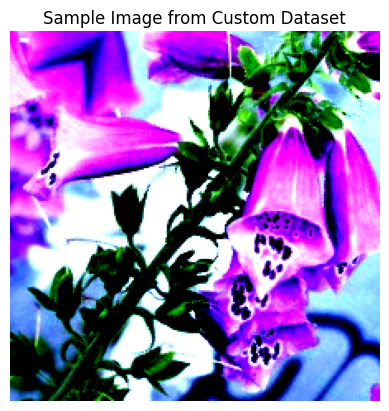

=== DataLoader Check ===


Number of batches in the DataLoader: 25 (* 512)
Images tensor batch: torch.Size([512, 3, 224, 224])
Labels tensor batch: torch.Size([512])
Label of the selected image: 67.0


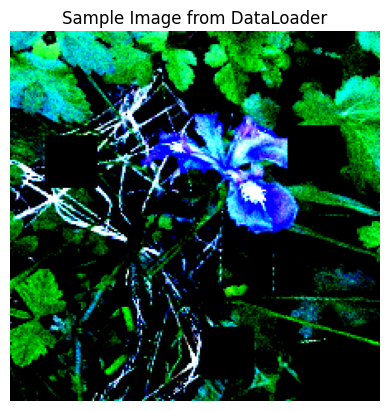

In [25]:
import random

import matplotlib.pyplot as plt


print("=== Custom Dataset Check ===")
img_tensor, lbl = custom_dataset[random.randint(0, len(custom_dataset) - 1)]
print(f"Total images in the dataset: {len(custom_dataset)}")
print(f"Image tensor shape: {img_tensor.shape}")
print(f"Image label: {lbl}")
plt.imshow(img_tensor.permute(1, 2, 0).detach().cpu().numpy())
plt.title("Sample Image from Custom Dataset")
plt.axis("off")
plt.show()

print("=== DataLoader Check ===")
imgs_tensor, lbls_tensor = next(iter(dataloader))
print(f"Number of batches in the DataLoader: {len(dataloader)} (* {batch_size})")
print(f"Images tensor batch: {imgs_tensor.shape}")
print(f"Labels tensor batch: {lbls_tensor.shape}")

index = random.randint(0, batch_size - 1)
img = imgs_tensor[index].permute(1, 2, 0).detach().cpu().numpy()
lbl = lbls_tensor[index]
print(f"Label of the selected image: {lbl}")
plt.imshow(img)
plt.title("Sample Image from DataLoader")
plt.axis("off")
plt.show()

In [27]:
!pip install wandb
!pip install lightning
!pip install timm

import os

import wandb


os.environ["WANDB_API_KEY"] = "3f27a3afb5700e7542c1fa3e3f210399ca7a9fb0"

wandb.login()


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


True

In [29]:
import lightning
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_lightning.loggers import WandbLogger
from sklearn.metrics import f1_score
from tqdm import tqdm


class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model("mobilenetv4_hybrid_medium.e500_r224_in1k", pretrained=True)
        self.model.fc = nn.Linear(self.model.num_features, 104)

    def forward(self, x):
        return self.model(x)


class LitModel(lightning.LightningModule):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.loss_fn = nn.NLLLoss()
        self.lr = 5e-3
        self.activation = F.log_softmax

    def forward(self, x):
        return self.encoder(x)

    def training_step(self, train_batch, batch_idx):
        train_imgs, train_lbls = train_batch
        predict_probas = self.activation(self(train_imgs), dim=1)
        loss = self.loss_fn(predict_probas, train_lbls)
        train_f1_score = f1_score(
            train_lbls.detach().cpu().numpy(),
            torch.argmax(predict_probas, dim=1).detach().cpu().numpy(),
            average="macro",
        )

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_f1_score", train_f1_score, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, val_batch, batch_idx):
        val_imgs, val_lbls = val_batch
        predict_probas = self.activation(self(val_imgs), dim=1)
        loss = self.loss_fn(predict_probas, val_lbls)
        val_f1_score = f1_score(
            val_lbls.detach().cpu().numpy(),
            torch.argmax(predict_probas, dim=1).detach().cpu().numpy(),
            average="macro",
        )

        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("val_f1_score", val_f1_score, on_step=True, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.5, patience=3
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {"scheduler": scheduler, "monitor": "val_loss"},
        }

In [30]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)
    random.seed(seed)


set_seed(42)

In [ ]:
from pytorch_lightning.loggers import WandbLogger


try:
    os.environ.pop("TPU_PROCESS_ADDRESSES")
except KeyError:
    print("already done")
try:
    os.environ.pop("CLOUD_TPU_TASK_ID")
except KeyError:
    print("already done")

num_epochs = 100
batch_size = 512
path = "/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224"

custom_dataset_train = CustomDataset(file_paths=get_recursive_paths(path, "train"), mode="train")
custom_dataset_val = CustomDataset(file_paths=get_recursive_paths(path, "val"), mode="val")

train_dataloader = DataLoader(
    custom_dataset_train, batch_size=batch_size, shuffle=True, num_workers=8
)
val_dataloader = DataLoader(custom_dataset_val, batch_size=batch_size, shuffle=True, num_workers=8)

wandb.finish()

xlm_model = LitModel()
logger = WandbLogger(project="kaggle_top11", log_model="all")

trainer = lightning.Trainer(logger=logger, max_epochs=num_epochs, accelerator="tpu")

trainer.fit(xlm_model, train_dataloader, val_dataloader)

already done


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: True, using: 8 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


/usr/local/lib/python3.10/site-packages/lightning/pytorch/strategies/xla.py:242: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/usr/local/lib/python3.10/site-packages/lightning/pytorch/strat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/site-packages/torch_xla/core/xla_model.py:1383: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  xldata.append(torch.load(xbio))
/usr/local/lib/python

/usr/local/lib/python3.10/site-packages/torch_xla/core/xla_model.py:1383: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  xldata.append(torch.load(xbio))
/usr/local/lib/python

Epoch 0: 100%|██████████| 4/4 [04:27<00:00,  0.01it/s, v_num=8i6y, train_loss_step=4.440, train_f1_score_step=0.00882]